In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [45]:
# === 1. Carregamento e limpeza do dataset ===
df = pd.read_csv("../data/CARGA_MENSAL.csv", sep=';', encoding='utf-8')
df['din_instante'] = pd.to_datetime(df['din_instante'])
df['ano'] = df['din_instante'].dt.year
df['mes'] = df['din_instante'].dt.month

# Corrige valores numéricos em formato brasileiro
df['val_cargaenergiamwmed'] = df['val_cargaenergiamwmed'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
df['val_cargaenergiamwmed'] = df['val_cargaenergiamwmed'].astype(float)

# Codifica o subsistema como número
le = LabelEncoder()
df['subsis_id'] = le.fit_transform(df['id_subsistema'])

C:\Users\EXGQ\AppData\Local\Temp\ipykernel_26260\3694285119.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['din_instante'] = pd.to_datetime(df['din_instante'])


In [46]:
# === 2. Criação de variáveis defasadas (lags) ===
df = df.sort_values(['subsis_id', 'din_instante'])
df['carga_t-1'] = df.groupby('subsis_id')['val_cargaenergiamwmed'].shift(1)
df['carga_t-12'] = df.groupby('subsis_id')['val_cargaenergiamwmed'].shift(12)
df = df.dropna()

In [47]:
# === 3. Definição de X e y ===
X = df[['ano', 'mes', 'subsis_id', 'carga_t-1', 'carga_t-12']]
y = df[['val_cargaenergiamwmed']]

# Escalonamento
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, stratify=X['subsis_id'], random_state=42
)

In [48]:
# === 4. Modelo com arquitetura reforçada ===
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/500


c:\Program Files\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0602 - mae: 0.1674 - val_loss: 0.0026 - val_mae: 0.0373
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0493 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0416 - val_loss: 0.0014 - val_mae: 0.0265
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0386 - val_loss: 0.0027 - val_mae: 0.0394
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mae: 0.0329 - val_loss: 0.0024 - val_mae: 0.0389
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0011 - val_mae: 0.0243
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mae: 0.0338 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - mae: 0.0275 - val_loss: 0.0027 - val_mae: 0.0408
Epoch 9/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.0

In [52]:
# === 5. Previsão de agosto/2025 ===
print("\nPrevisão de carga para agosto/2025:")
for sigla in le.classes_:
    sid = le.transform([sigla])[0]
    ult_linha = df[df['subsis_id'] == sid].sort_values('din_instante').iloc[-1]
    entrada = pd.DataFrame([[2025, 8, sid, ult_linha['val_cargaenergiamwmed'], ult_linha['carga_t-12']]],
                           columns=['ano', 'mes', 'subsis_id', 'carga_t-1', 'carga_t-12'])
    entrada_scaled = scaler_X.transform(entrada)
    pred_scaled = model.predict(entrada_scaled)
    pred = scaler_y.inverse_transform(pred_scaled)[0][0]
    print(f"{sigla}: {pred:.2f} MW médios")



Previsão de carga para agosto/2025:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
N: 6751.19 MW médios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
NE: 11226.52 MW médios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
S: 11583.35 MW médios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
SE: 43859.33 MW médios


In [53]:
# === 6. Avaliação por Subsistema ===
X_test_unscaled = scaler_X.inverse_transform(X_test)
print("\nAvaliação por Subsistema:")
for sigla in le.classes_:
    sid = le.transform([sigla])[0]
    mask = X_test_unscaled[:, 2] == sid

    if not np.any(mask):
        continue

    y_real = scaler_y.inverse_transform(y_test[mask]).ravel()
    y_pred = scaler_y.inverse_transform(model.predict(X_test[mask])).ravel()

    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    r2 = r2_score(y_real, y_pred)

    print(f"\nSubsistema {sigla}:")
    print(f"  MAE:  {mae:.2f} MW médios")
    print(f"  RMSE: {rmse:.2f} MW médios")
    print(f"  R²:   {r2:.4f}")


Avaliação por Subsistema:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Subsistema N:
  MAE:  302.09 MW médios
  RMSE: 411.35 MW médios
  R²:   0.9167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Subsistema NE:
  MAE:  771.89 MW médios
  RMSE: 955.47 MW médios
  R²:   0.8463
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Subsistema S:
  MAE:  982.07 MW médios
  RMSE: 1084.62 MW médios
  R²:   0.7330
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Subsistema SE:
  MAE:  2031.07 MW médios
  RMSE: 2364.24 MW médios
  R²:   0.8755


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


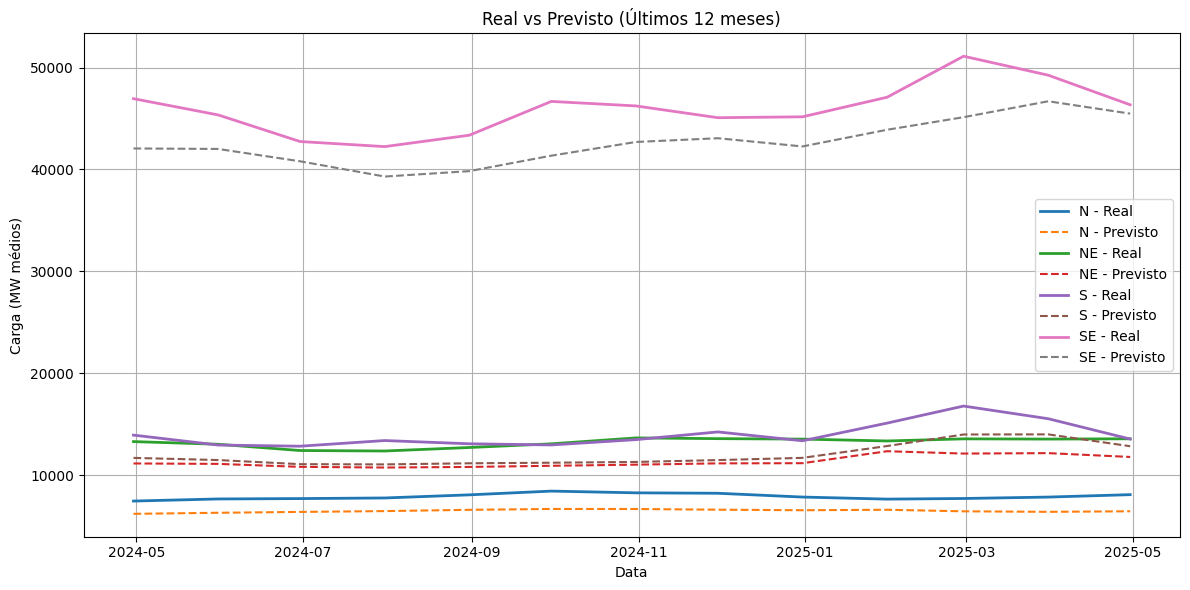

In [54]:
# === 7. Gráfico Real vs Previsto (últimos 12 meses) ===
last_12 = df[df['din_instante'] >= df['din_instante'].max() - pd.DateOffset(months=12)]

plt.figure(figsize=(12, 6))
for sigla in le.classes_:
    sid = le.transform([sigla])[0]
    real = last_12[last_12['subsis_id'] == sid].copy()
    real = real.sort_values('din_instante')

    X_pred = real[['ano', 'mes', 'subsis_id', 'carga_t-1', 'carga_t-12']]
    X_pred_scaled = scaler_X.transform(X_pred)
    y_pred_scaled = model.predict(X_pred_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()

    plt.plot(real['din_instante'], real['val_cargaenergiamwmed'], label=f"{sigla} - Real", linewidth=2)
    plt.plot(real['din_instante'], y_pred, '--', label=f"{sigla} - Previsto", linewidth=1.5)

plt.title("Real vs Previsto (Últimos 12 meses)")
plt.ylabel("Carga (MW médios)")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()